## Load and predictions
Get the load that is going to be tested and its predictions

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.keras.models import load_model

# get an absolute path to the directory that contains parent files
project_dir = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..")))

from barazmoon.twitter import twitter_workload_generator

from experiments.utils.constants import PROJECT_PATH, LSTM_PATH, LSTM_INPUT_SIZE

2023-06-01 13:15:01.950618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 13:15:02.104816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-01 13:15:02.104842: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-01 13:15:02.133475: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-01 13:15:02.665727: W tensorflow/stream_executor/pla

2023-06-01 13:15:04.454487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-01 13:15:04.454511: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-01 13:15:04.454559: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (microk8s-cluster-1): /proc/driver/nvidia/version does not exist
2023-06-01 13:15:04.454788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 4ms/step


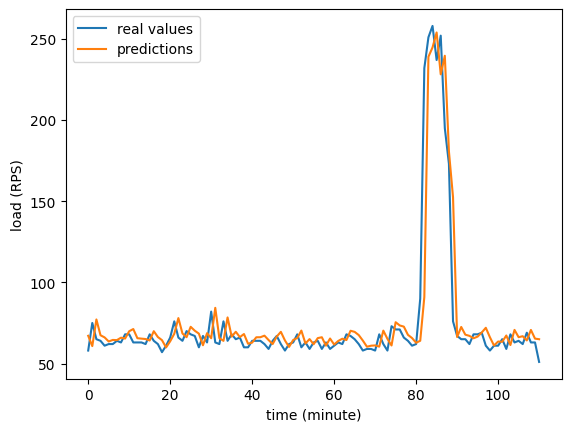

In [2]:
fig_path = os.path.join(PROJECT_PATH, "lstm-module", "lstm_prediction.png")

# TODO HERE fix in the easiest way

model = load_model(LSTM_PATH)
# workload = twitter_workload_generator('1-2')
workload = twitter_workload_generator("2:0:0:0-2:2:0:0")
workload = list(filter(lambda x: x != 0, workload))  # for removing missing hours
hour = 60 * 60
day = hour * 24
# test_idx = 18 * day
test_idx = 0
# test_data = workload[test_idx:test_idx + 2 * hour]
test_data = workload


def get_x_y(data):
    """
    For each 60 seconds it taeks the max of last 60 seconds
    and returns an output with length of len(data)/60 that
    each entry is the maximum rps in each aggregated 60 seconds
    x: series of max of every 1 minute
    y: target of the 10 minutes
    """
    x = []
    y = []
    history_seconds = 600
    for i in range(0, len(data) - history_seconds, 60):
        t = data[i : i + history_seconds]
        for j in range(0, len(t), 60):
            x.append(max(t[j : j + 60]))
        y.append(max(data[i + history_seconds : i + history_seconds + 60]))
    return x, y


test_x, test_y = get_x_y(test_data)

test_x = tf.convert_to_tensor(
    np.array(test_x).reshape((-1, LSTM_INPUT_SIZE, 1)), dtype=tf.float32
)
prediction = model.predict(test_x)
plt.plot(list(range(len(test_y))), list(test_y), label="real values")
plt.plot(list(range(len(test_y))), list(prediction), label="predictions")
plt.xlabel("time (minute)")
plt.ylabel("load (RPS)")
plt.legend()
plt.savefig(fig_path)

In [3]:
workload = twitter_workload_generator("1:0:0-1:2:0")
len(workload)

7201

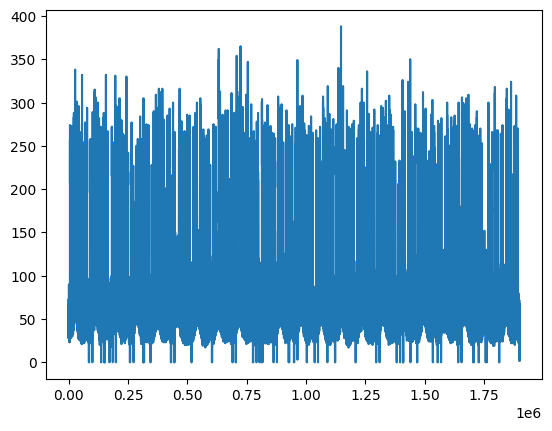

In [4]:
workload = twitter_workload_generator("1:0:0-23:0:0")
plt.plot(workload)

In [5]:
# %matplotlib widget
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.widgets import Slider

# fig, ax = plt.subplots()
# plt.subplots_adjust(bottom=0.25)

# workload = twitter_workload_generator("1:0:0-23:0:0")
# t = np.arange(0.0, len(workload), 1)
# workload = workload
# (l,) = plt.plot(t, workload)
# window_size = 12 * 3600
# plt.axis([0, window_size, 0, max(workload)])

# axcolor = "lightgoldenrodyellow"
# axpos = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor=axcolor)

# spos = Slider(axpos, "Pos", 0.1, len(workload) - 10.0)


# def update(val):
#     pos = spos.val
#     ax.axis([pos, pos + window_size, 0, max(workload)])
#     fig.canvas.draw_idle()


# spos.on_changed(update)

# plt.show()

# Bursty Workload

### 10 minutes

start: 1862950
end: 1863550


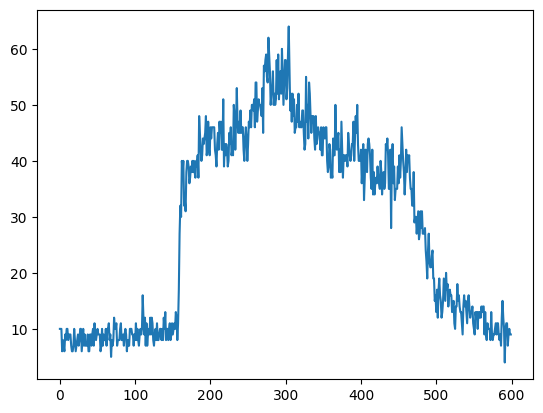

In [6]:
# Plot subpart based on above
%matplotlib inline
start = 1862950
end = 1863550
# selected_workload = workload[start:end]
selected_workload = twitter_workload_generator(f"{start}-{end}", damping_factor=5)
plt.plot(selected_workload)
print(f"start: {start}")
print(f"end: {end}")

In [7]:
sublists = [selected_workload[i] for i in range(0, len(selected_workload), 30)]
indices = [i for i in range(0, len(selected_workload), 30) if i % 15 == 0]
print("Sublists:", sublists)
print("Len Sublists:", len(sublists))
print("Indices:", indices)
print("Len Indices:", len(indices))

Sublists: [10, 8, 8, 8, 12, 9, 37, 45, 49, 45, 58, 44, 37, 47, 37, 36, 28, 19, 13, 10]
Len Sublists: 20
Indices: [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570]
Len Indices: 20


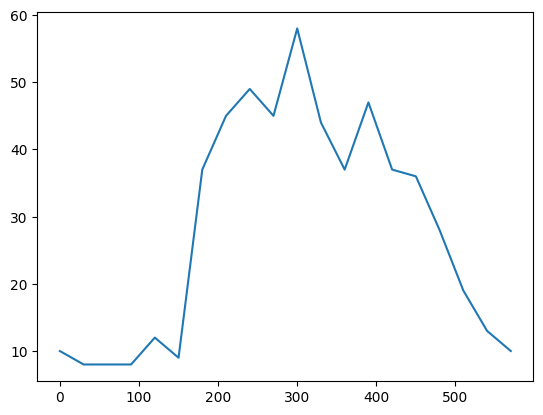

In [8]:
plt.plot(indices, sublists)

In [9]:
selected_workload

[10,
 10,
 10,
 6,
 8,
 7,
 6,
 9,
 8,
 10,
 10,
 8,
 9,
 9,
 9,
 7,
 6,
 6,
 7,
 10,
 8,
 6,
 7,
 8,
 9,
 7,
 8,
 10,
 10,
 6,
 8,
 10,
 7,
 9,
 7,
 7,
 7,
 9,
 6,
 6,
 9,
 9,
 7,
 9,
 10,
 7,
 11,
 9,
 8,
 9,
 10,
 9,
 9,
 9,
 6,
 7,
 10,
 7,
 9,
 8,
 8,
 10,
 7,
 10,
 10,
 11,
 8,
 9,
 5,
 8,
 7,
 8,
 12,
 10,
 10,
 11,
 7,
 8,
 8,
 8,
 10,
 11,
 8,
 8,
 9,
 7,
 9,
 10,
 9,
 6,
 8,
 7,
 7,
 10,
 10,
 10,
 9,
 9,
 7,
 9,
 8,
 11,
 8,
 10,
 8,
 7,
 9,
 10,
 9,
 10,
 16,
 12,
 9,
 12,
 7,
 11,
 7,
 9,
 10,
 9,
 12,
 9,
 12,
 11,
 8,
 7,
 9,
 10,
 8,
 11,
 8,
 8,
 9,
 10,
 10,
 8,
 10,
 8,
 12,
 10,
 13,
 8,
 10,
 10,
 8,
 10,
 11,
 8,
 9,
 11,
 9,
 10,
 11,
 10,
 13,
 12,
 8,
 11,
 17,
 27,
 32,
 30,
 40,
 38,
 40,
 32,
 33,
 31,
 38,
 40,
 40,
 39,
 36,
 37,
 39,
 38,
 40,
 38,
 40,
 38,
 37,
 40,
 39,
 41,
 37,
 48,
 45,
 42,
 40,
 41,
 44,
 43,
 44,
 45,
 48,
 41,
 42,
 47,
 42,
 41,
 46,
 44,
 46,
 46,
 46,
 46,
 42,
 41,
 39,
 43,
 45,
 42,
 47,
 45,
 47,
 42,
 42,
 51,
 39,
 43,


### 20 minutes

start: 1851800
end: 1853000


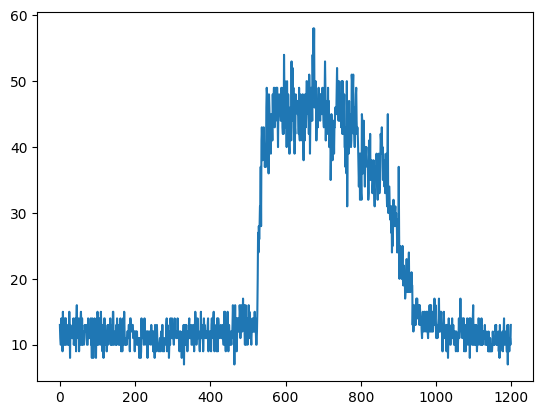

In [10]:
# Plot subpart based on above
%matplotlib inline
start = 1851800
end = 1853000
# selected_workload = workload[start:end]
selected_workload = twitter_workload_generator(f"{start}-{end}", damping_factor=5)
plt.plot(selected_workload)
print(f"start: {start}")
print(f"end: {end}")

# Steady Low Workload

### 10 minutes

start: 1860700
end: 1861300


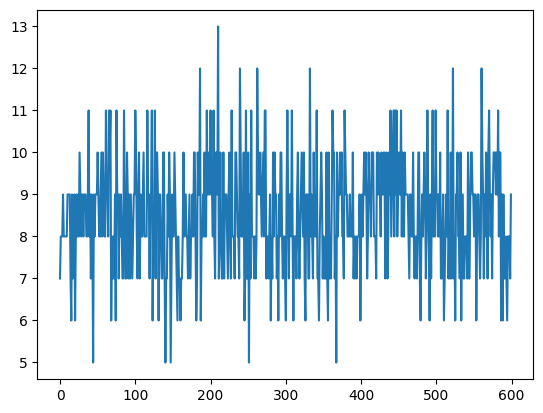

In [11]:
# Plot subpart based on above
%matplotlib inline
start = 1860700
end = 1861300
# selected_workload = workload[start:end]
selected_workload = twitter_workload_generator(f"{start}-{end}", damping_factor=5)
plt.plot(selected_workload)
print(f"start: {start}")
print(f"end: {end}")

### 20 minutes

start: 1855600
end: 1856800


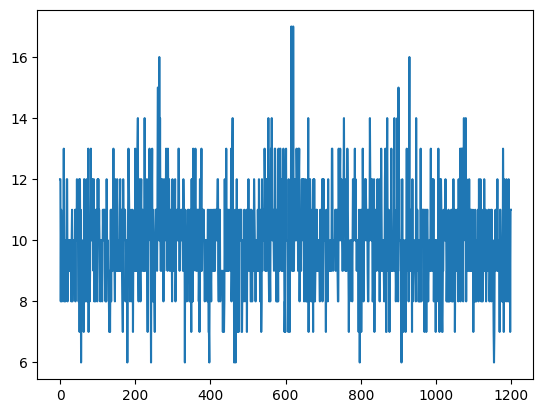

In [12]:
# Plot subpart based on above
%matplotlib inline
start = 1855600
end = 1856800
# selected_workload = workload[start:end]
selected_workload = twitter_workload_generator(f"{start}-{end}", damping_factor=5)
plt.plot(selected_workload)
print(f"start: {start}")
print(f"end: {end}")

# Steady High Workload

### 10 minutes

start: 1877540
end: 1878140


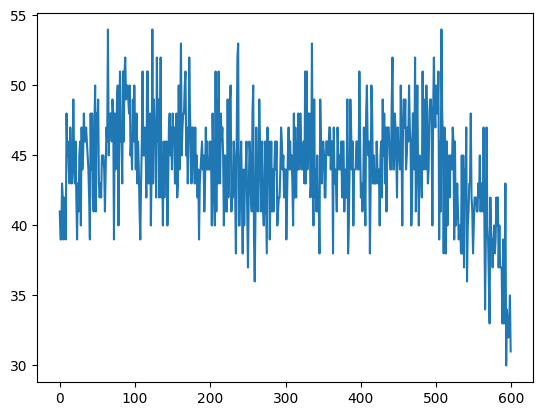

In [13]:
# Plot subpart based on above
%matplotlib inline
start = 1877540
end = 1878140
# selected_workload = workload[start:end]
selected_workload = twitter_workload_generator(f"{start}-{end}", damping_factor=5)
plt.plot(selected_workload)
print(f"start: {start}")
print(f"end: {end}")

start: 1429600
end: 1430200


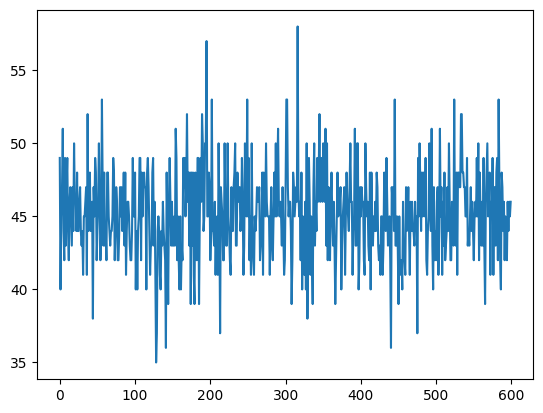

In [14]:
# Plot subpart based on above
%matplotlib inline
start = 1429600
end = 1430200
# selected_workload = workload[start:end]
selected_workload = twitter_workload_generator(f"{start}-{end}", damping_factor=5)
plt.plot(selected_workload)
print(f"start: {start}")
print(f"end: {end}")